In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import sys
sys.path.append('GAN')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
import numpy as np
from tensorflow.keras.datasets import mnist
# load data
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# utility function
import scipy
import moviepy.editor as mpy
def visualize_imgs(imgs, shape, save_path=None):
    (row, col) = shape[0], shape[1]
    height, width = imgs[0].shape[:2]
    total_img = np.zeros((height*row, width*col))
    for n, img in enumerate(imgs):
        j = int(n/col)
        i = n%col
        total_img[j*height:(j+1)*height,i*width:(i+1)*width] = img
    if save_path is not None:
        scipy.misc.imsave(save_path, img)
    return total_img
  
def make_gif(images, fname, duration=2, true_image=False):    
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x+1)/2*255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
def iter_data(*data, **kwargs):
    size = kwargs.get('batch_size', 128)
    try:
        n = len(data[0])
    except:
        n = data[0].shape[0]
    batches = int(n / size)
    if n % size != 0:
        batches += 1
    for b in range(batches):
        start = b * size
        end = (b + 1) * size
        if end > n:
            end = n
        if len(data) == 1:
            yield data[0][start:end]
        else:
            yield tuple([d[start:end] for d in data])
class DCGAN(object):
    def __init__(self, image_size, image_channel, z_dim=128, learning_rate=1e-4):
        self.image_size = image_size
        self.image_channel = image_channel
        self.z_dim = z_dim
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_real, labels=tf.ones_like(self.logit_real)))
        self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake, labels=tf.zeros_like(self.logit_fake)))
        self.d_loss = self.d_loss_real + self.d_loss_fake

        # loss of generator
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake, labels=tf.ones_like(self.logit_fake)))
       
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss, var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss, var_list=self.g_vars)

    def discriminator(self, image):
        lrelu = tf.nn.leaky_relu
        conv2d = tf.layers.conv2d
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense    
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
            if self.image_channel==1:
                image = tf.reshape(image, [-1, self.image_size, self.image_size, 1])
            hidden = self.z
            hidden = image
            hidden = lrelu(conv2d(hidden, 32, kernel_size=5, strides=2, padding='same'))
            hidden = lrelu(bn(conv2d(hidden, 128, kernel_size=5, strides=2, padding='same'), training=True))
            hidden = tf.layers.flatten(hidden)
            hidden = lrelu(bn(linear(hidden, 1024), training=True))
            hidden = linear(hidden, 1)
            return tf.nn.sigmoid(hidden), hidden

    def generator(self, y=None):
        relu = tf.nn.relu
        deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("generator"):
            self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
            hidden = self.z
            hidden = relu(bn(linear(hidden, 1024), training=True))
            hidden = relu(bn(linear(hidden, (self.image_size//4)*(self.image_size//4)*128), training=True))
            hidden = tf.reshape(hidden, [-1, self.image_size//4, self.image_size//4, 128])
            hidden = relu(bn(deconv2d(hidden, 32, kernel_size=5, strides=2, padding='same'), training=True))
            hidden = tf.nn.sigmoid(deconv2d(hidden, self.image_channel, kernel_size=5, strides=2, padding='same'))
            if self.image_channel==1:
                hidden = tf.reshape(hidden, [-1, self.image_size, self.image_size])
            return hidden
          
    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100, show_samples=True, sample_path='./samples', 
              n_critic=2, log=False):
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1, [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op], feed_dict=feed_dict)
                    d_losses.append(d_loss)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op], feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20), save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch
      
    def save_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=step)
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name+'-{}'.format(step)))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))

In [159]:
#Inherit from DCGAN class
LAMBDA = 10.0
class IWGAN(DCGAN):
    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of generator
        self.g_loss = -tf.reduce_mean(self.logit_fake)
        
        # loss of discriminator                  
        self.d_loss = tf.reduce_mean(self.logit_fake)  -  tf.reduce_mean(self.logit_real)

        
        BATCH_SIZE = tf.shape(self.image_fake)[0]

#         differences = self.image_fake - self.image_real
        self.epsilon = tf.random_uniform(
                        shape=[BATCH_SIZE,1,1], 
                        minval=0.,
                        maxval=1.
                        )
        interpolates = self.image_real*self.epsilon + (1.0-self.epsilon)*self.image_fake
        gradients = tf.gradients( self.discriminator(interpolates)[0], [interpolates])[0]
#         print(gradients.shape)# ?,28,28
        self.slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2]))

        self.gradient_penalty = tf.reduce_mean((self.slopes-1.)**2)
        self.d_loss += (LAMBDA*self.gradient_penalty)
    
    
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(1e-4,beta1=0.0,beta2=0.9).minimize(self.d_loss, var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(1e-4,beta1=0.0,beta2=0.9).minimize(self.g_loss, var_list=self.g_vars)
        
#         # create weight cliping operation
#         self.weight_clip_ops = []
#         for var in self.d_vars:            
#             self.weight_clip_ops.append(var.assign(tf.clip_by_value(var, -0.01, 0.01)))
            
    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100, show_samples=True, n_critic=2, 
              sample_path='./samples', log=False): 
    
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()        
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1, [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _,g = sess.run([self.d_loss, self.d_update_op,self.slopes], feed_dict=feed_dict)
                    d_losses.append(d_loss)
#                     print(max(g),d_loss)
#                     sess.run(self.weight_clip_ops)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op], feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1                                        
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20), save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                self.save_model(sess, step=counter)
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch

In [160]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
iwgan = IWGAN(image_size=28, image_channel=1)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

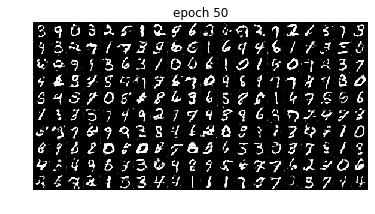

In [162]:
# Start training
sample_imgs, d_loss_epoch, g_loss_epoch = iwgan.train(sess, x_train, num_sample=200, num_epoch=50, n_critic=5)

In [165]:
imgs = np.array(sample_imgs)
make_gif(imgs*255., './iwgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='./iwgan.gif') 


[MoviePy] Building file ./iwgan.gif with imageio


 98%|█████████▊| 50/51 [00:00<00:00, 81.88it/s]


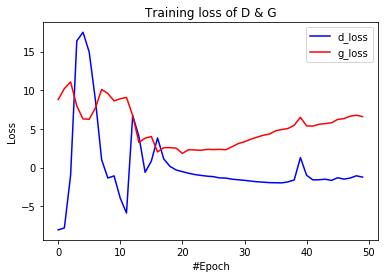

In [164]:
plt.plot(range(len(d_loss_epoch)), d_loss_epoch, color = 'blue', label = 'd_loss')
plt.plot(range(len(g_loss_epoch)), g_loss_epoch, color = 'red', label = 'g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

# According to the paper's descripiton in page 5, the author claims that the discriminator without batch norm performs better. Let's try.

In [169]:
class DCGAN(object):
    def __init__(self, image_size, image_channel, z_dim=128, learning_rate=1e-4):
        self.image_size = image_size
        self.image_channel = image_channel
        self.z_dim = z_dim
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        if self.image_channel==1:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size])
        else:
            self.image_real = tf.placeholder(tf.float32, [None, self.image_size, self.image_size, self.image_channel])
            
        # create generator
        self.image_fake = self.generator()
        
        # create discriminator and get its prediction for real/fake image
        self.pred_real, self.logit_real = self.discriminator(self.image_real)
        self.pred_fake, self.logit_fake = self.discriminator(self.image_fake)

        # loss of discriminator
        self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_real, labels=tf.ones_like(self.logit_real)))
        self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake, labels=tf.zeros_like(self.logit_fake)))
        self.d_loss = self.d_loss_real + self.d_loss_fake

        # loss of generator
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                          logits=self.logit_fake, labels=tf.ones_like(self.logit_fake)))
       
        # create optimize operation for discriminator
        self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
        self.d_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.d_loss, var_list=self.d_vars)
        
        # create optimize operation for generator
        self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
        self.g_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.g_loss, var_list=self.g_vars)

    def discriminator(self, image):
        lrelu = tf.nn.leaky_relu
        conv2d = tf.layers.conv2d

        linear = tf.layers.dense    
        with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
            if self.image_channel==1:
                image = tf.reshape(image, [-1, self.image_size, self.image_size, 1])
            hidden = self.z
            hidden = image
            hidden = lrelu(conv2d(hidden, 32, kernel_size=5, strides=2, padding='same'))
            hidden = lrelu(conv2d(hidden, 128, kernel_size=5, strides=2, padding='same'), training=True)
            hidden = tf.layers.flatten(hidden)
            hidden = lrelu(linear(hidden, 1024), training=True)
            hidden = linear(hidden, 1)
            return tf.nn.sigmoid(hidden), hidden

    def generator(self, y=None):
        relu = tf.nn.relu
        deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope("generator"):
            self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')
            hidden = self.z
            hidden = relu(bn(linear(hidden, 1024), training=True))
            hidden = relu(bn(linear(hidden, (self.image_size//4)*(self.image_size//4)*128), training=True))
            hidden = tf.reshape(hidden, [-1, self.image_size//4, self.image_size//4, 128])
            hidden = relu(bn(deconv2d(hidden, 32, kernel_size=5, strides=2, padding='same'), training=True))
            hidden = tf.nn.sigmoid(deconv2d(hidden, self.image_channel, kernel_size=5, strides=2, padding='same'))
            if self.image_channel==1:
                hidden = tf.reshape(hidden, [-1, self.image_size, self.image_size])
            return hidden
          
    def train(self, sess, x_train, num_epoch=100, batch_size=100, num_sample=100, show_samples=True, sample_path='./samples', 
              n_critic=2, log=False):
        # sample some random noise, these noise is used to monitor generated image 
        sample_z = np.random.uniform(-1, 1, size=(num_sample , self.z_dim))
        sample_imgs = []
        
        counter = 1
        start_time = time.time()
        d_loss_epoch = []
        g_loss_epoch = []
        for epoch in range(num_epoch):
            shuffle_idx = np.random.permutation(len(x_train))
            x_train = x_train[shuffle_idx]
            d_losses = []
            g_losses = []
            for batch_images in iter_data(x_train, batch_size=batch_size):
                batch_z = np.random.uniform(-1, 1, [batch_size, self.z_dim]).astype(np.float32)
                if counter % (n_critic+1) != 0:
                    # Update D network
                    feed_dict={ 
                        self.image_real: batch_images,
                        self.z: batch_z,
                    }
                    d_loss, _ = sess.run([self.d_loss, self.d_update_op], feed_dict=feed_dict)
                    d_losses.append(d_loss)
                else:
                    # Update G network
                    g_loss, _ = sess.run([self.g_loss, self.g_update_op], feed_dict={self.z: batch_z})
                    g_losses.append(g_loss)
                counter += 1
            if log:
                print("Epoch: [{}] time: {:.2f}, d_loss: {:.4f}, g_loss: {:.4f}".format(
                      epoch, time.time()-start_time, np.mean(d_losses), np.mean(g_losses)))
            d_loss_epoch.append(np.mean(d_losses))
            g_loss_epoch.append(np.mean(g_losses))
            
            # save generated samples
            samples = sess.run(self.image_fake, feed_dict={self.z: sample_z})
            if not os.path.exists(sample_path):
                os.makedirs(sample_path)
            img = visualize_imgs(samples, shape=(10,20), save_path=sample_path+'/epoch-{}.jpg'.format(epoch))
            sample_imgs.append(img)
                
            if (epoch+1) % 10 == 0:
                if show_samples:
                    plt.imshow(img, cmap = 'gray')
                    plt.axis('off')
                    plt.title('epoch {}'.format(epoch+1))
                    plt.show()
        return sample_imgs, d_loss_epoch, g_loss_epoch
      
    def save_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name), global_step=step)
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', model_name='model', step=None):
        saver = tf.train.Saver()
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, model_name+'-{}'.format(step)))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, model_name))

In [170]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
iwgan = IWGAN(image_size=28, image_channel=1)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

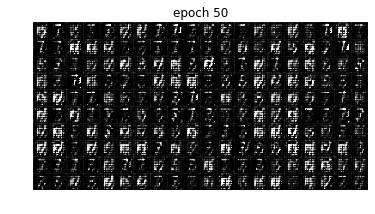

In [171]:
# Start training
sample_imgs, d_loss_epoch, g_loss_epoch = iwgan.train(sess, x_train, num_sample=200, num_epoch=50, n_critic=5)

In [173]:
imgs = np.array(sample_imgs)
make_gif(imgs*255., './iwgan_no_batchN.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='./iwgan_no_batchN.gif') 


[MoviePy] Building file ./iwgan_no_batchN.gif with imageio


 98%|█████████▊| 50/51 [00:00<00:00, 70.13it/s]


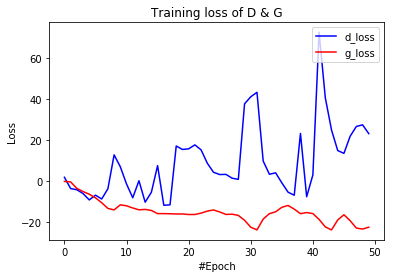

In [174]:
plt.plot(range(len(d_loss_epoch)), d_loss_epoch, color = 'blue', label = 'd_loss')
plt.plot(range(len(g_loss_epoch)), g_loss_epoch, color = 'red', label = 'g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

# The output doesn't look well , which isn't consistent with author's description.
    >The discriminator loss actually diverges without batch normalization
    >Maybe I need to change some hyperparameters to make this work

# Come up or survey some applications of GAN. Write in or paste link in notebook.
    >Anime girl face generator
        https://towardsdatascience.com/mangagan-8362f06b9625
    >Face Aging
        https://arxiv.org/pdf/1702.08423.pdf
    >Super-resolution
        https://github.com/david-gpu/srez
    
# Write a brief report about what you learn.

    >According to the generated gif image, improved WGAN do generate clear image faster than WGAN 
    >The loss function design of WGAN-gp enhence the training progression of the discriminator. In the initial stage,
    the generator always generate noise images which is too easy for discriminator. By averaging the generated image with 
    real image could solve this problem and this is why WGAN-gp works in my opinion.